In [120]:
import numpy as np
import dlib
import cv2
from collections import OrderedDict
import imutils
from matplotlib import pyplot as plt
import face_recognition

In [121]:
from PIL import Image, ImageDraw
import face_recognition

IMAGE_PATH = "../images/musician_farrah/00001.jpg"

# Load the jpg file into a numpy array
image = face_recognition.load_image_file(IMAGE_PATH)

# Find all facial features in all the faces in the image
face_landmarks_list = face_recognition.face_landmarks(image, model='large')

print(f"No. of faces found: {len(face_landmarks_list)}")

No. of faces found: 1


Obtain the bounding box(es) of the face

In [122]:
image = face_recognition.load_image_file(IMAGE_PATH)
face_locations = face_recognition.face_locations(image)

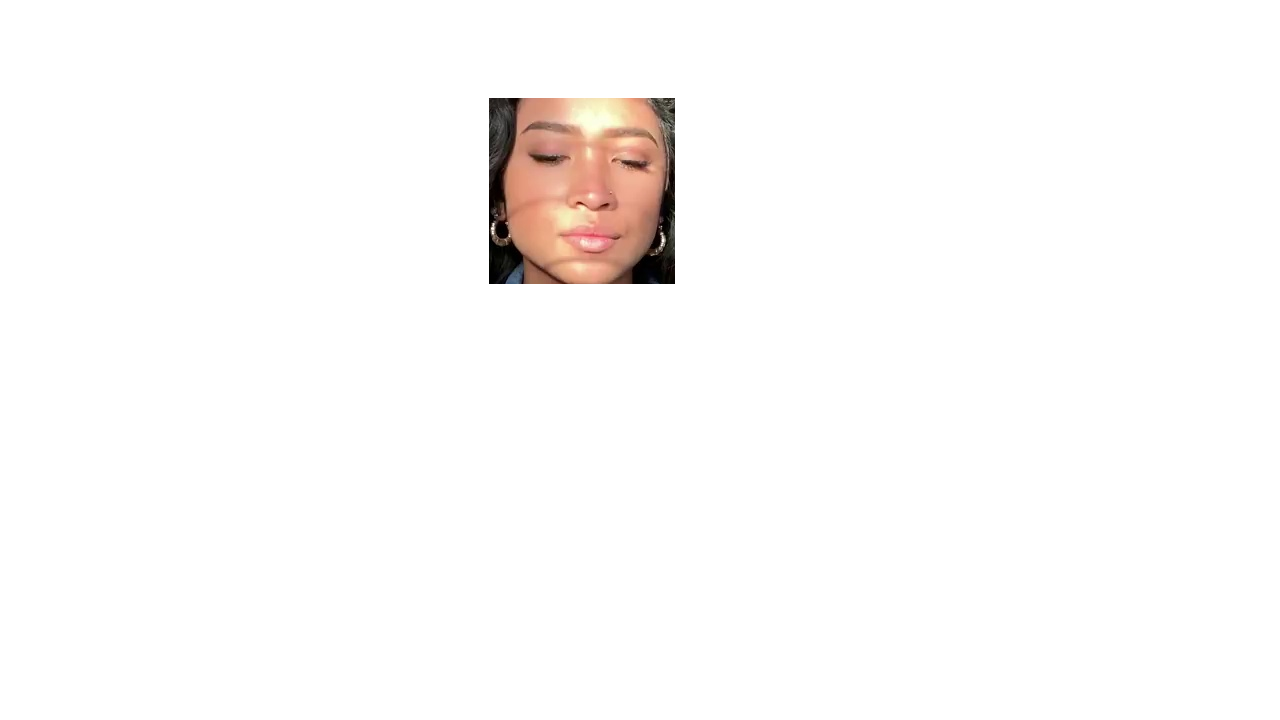

In [138]:
# simply visualise only the face
faces_image = np.ones_like(image) * 255

for face_location in face_locations:    
    top, right, bottom, left = face_location
    faces_image[top:bottom, left:right] = image[top:bottom, left:right]
    
pil_image = Image.fromarray(faces_image)

# to show PIL image in a window
# pil_image.show(title="face")

pil_image

In [142]:
image.shape

(720, 1280, 3)

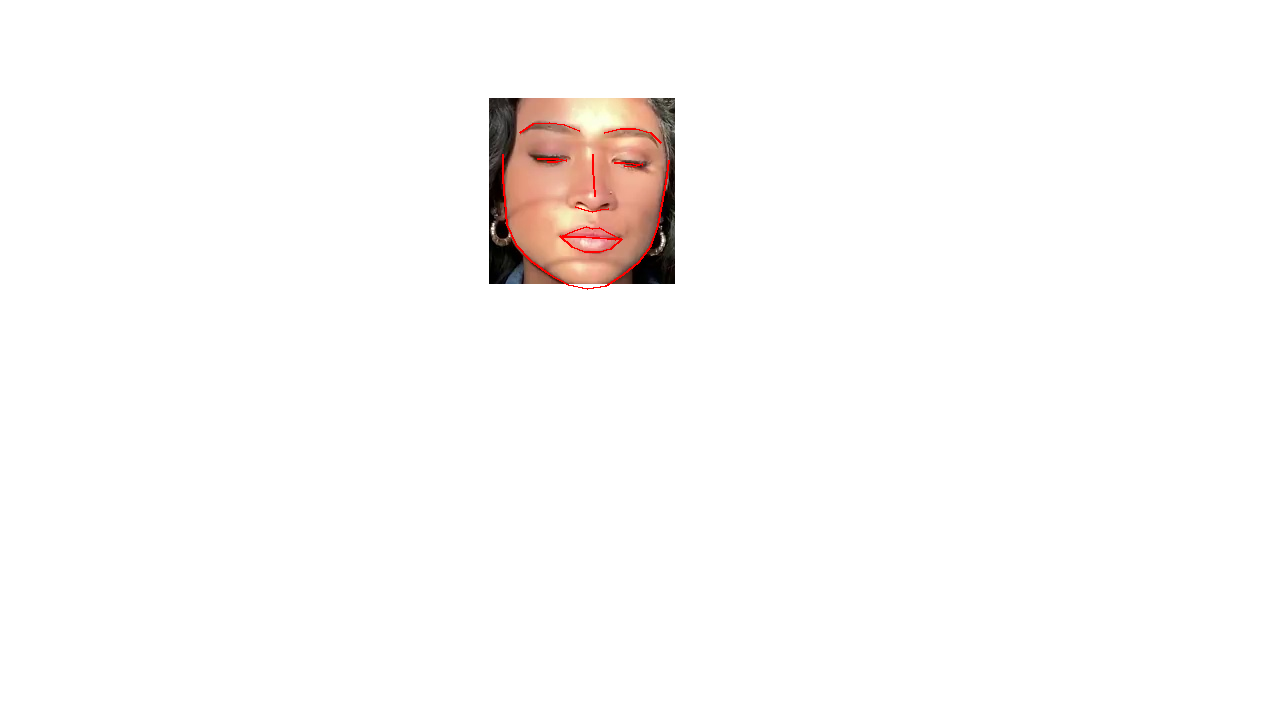

In [137]:
# plot directly on the face
pil_image = Image.fromarray(faces_image)

# for each face's landmarks
for face_landmarks in face_landmarks_list:
    d = ImageDraw.Draw(pil_image, 'RGB')
    
    # draw the facial landmarks
    for face_landmark in face_landmarks:
        d.line(face_landmarks[face_landmark], fill=(255, 0, 0), width=2)

# to show PIL image in a window
# pil_image.show(title="face outline(s)")
pil_image

In [145]:
face_location

(98, 675, 284, 489)

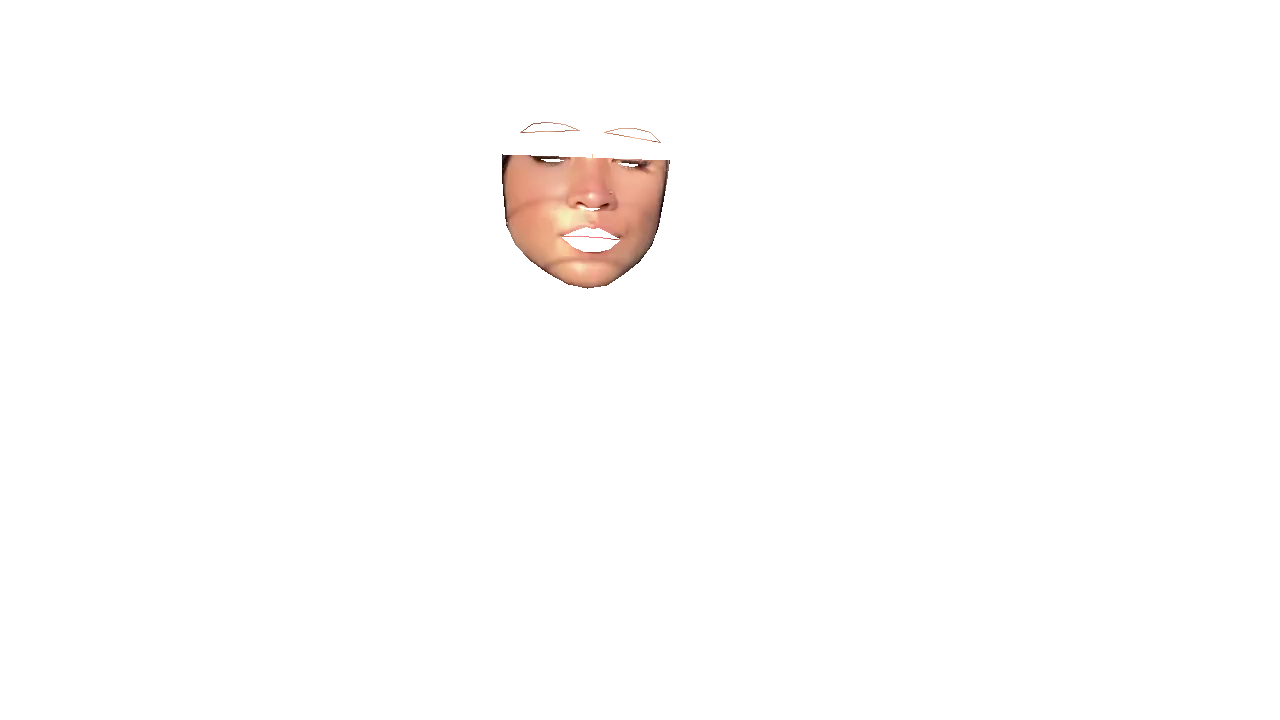

In [160]:
import numpy as np
from PIL import Image, ImageDraw

def extract_skin(img, face_location, face_landmarks):
    '''
    Given an image of only the face, extract out the left and right eyes, top and bottom lips.
    
    :param img: an image read using Python Imaging Library (PIL)
    :type img: PIL.Image.Image
    
    :param face_location: coordinates indicating where the face is in `img`
    :type face_location: list of length 4, representing top, right, bottom, left
    
    :param face_landmarks: a dictionary of list of points that describe the points of each 
        face landmark, for e.g.
        ```
        {'left_eye': [(520, 132), (533, 123), (549, 122), (564, 124), (579, 130)],
         'right_eye': [(604, 132), (620, 128), (635, 128), (650, 132), (660, 142)]}
        ```
    :type face_landmarks: dictionary of iterable of iterable of 2 int
    '''
    
    # convert to numpy (for convenience)
    imArray = np.asarray(img)
    
    ##################### retain face area only ####################
    # create mask full of ones, essentially an image with zero-values
    maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
    
    top, right, bottom, left = face_location
    
    face_bounding_box = [(left,top),
                         (right,top),
                         (right,bottom),
                         (left,bottom)]
    
    d = ImageDraw.Draw(maskIm)
    
    # extract only the face
    d.polygon(face_landmarks['chin'], outline=1, fill=1)

    # obtain the pixel values from the PIL image
    mask = np.array(maskIm)

    # assemble new image (uint8: 0-255)
    newImArray = np.empty(imArray.shape,dtype='uint8')

    # colors (three first columns, RGB)
    newImArray[:,:,:3] = imArray[:,:,:3]

    # transparency (4th column)
    newImArray[:,:,3] = mask*255

    # back to Image from numpy
#     newIm = Image.fromarray(newImArray, "RGBA")
    
#     return newIm 
    
    
    ##################### remove face landmarks ####################
    # create mask full of ones    
    d = ImageDraw.Draw(maskIm)
    
    # for each facial landmark ...
    for face_landmark in face_landmarks:
        if face_landmark == 'chin':
            continue
        
        # create a polygon full of zeros wihtin the mask of ones
        polygon = face_landmarks[face_landmark]
        d.polygon(polygon, outline=1, fill=0)

    # obtain the pixel values from the PIL image
    mask = np.array(maskIm)

    # assemble new image (uint8: 0-255)
    finalImArray = np.empty(newImArray.shape,dtype='uint8')

    # colors (three first columns, RGB)
    finalImArray[:,:,:3] = newImArray[:,:,:3]

    # transparency (4th column)
    finalImArray[:,:,3] = mask*255

    # back to Image from numpy
    newIm = Image.fromarray(finalImArray, "RGBA")
    
    return newIm
    

# read image as RGB and add alpha (transparency)
img = Image.open(IMAGE_PATH).convert("RGBA")
extract_skin = extract_skin(img, face_location,face_landmarks)
extract_skin

In [200]:
skin_colours = []
pixel_values = np.asarray(extract_skin)

height, width, channels = pixel_values.shape

for i in range(height):
    for j in range(width):
        colour = pixel_values[i][j]
        
        if colour[3] != 0:
            skin_colours.append(colour[:3])
            
skin_colours = np.asarray(skin_colours)
skin_colours

array([[165, 113,  99],
       [171, 119, 106],
       [171, 122, 108],
       ...,
       [115,  67,  53],
       [116,  68,  54],
       [ 85,  39,  24]], dtype=uint8)

In [224]:
skin_tone = np.asarray(np.mean(skin_colours, axis=0), dtype=int)
skin_tone

array([208, 146, 121])

In [240]:
def rgb_to_hex(rgb):
    int_to_hex = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4',
                  5:'5', 6:'6', 7:'7', 8:'8', 9:'9',
                  10:'A', 11:'B', 12:'C', 13:'D',
                  14:'E', 15:'F'}
    hex_code = '#'
    
    for channel in rgb:
        hex_code += hex(channel)[-2:]
    
    return hex_code

hex_skin_tone = rgb_to_hex(skin_tone)
hex_skin_tone

'#d09279'

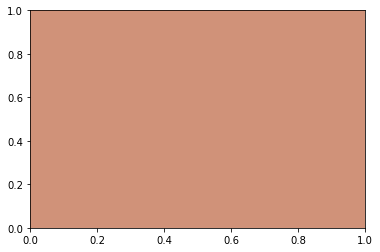

In [241]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots()

# Create a Rectangle patch
rect = patches.Rectangle((0, 0), 50, 30, fill=True, linewidth=1, color=hex_skin_tone)

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()